In [22]:
# %matplotlib notebook
from sklearn.preprocessing import StandardScaler,QuantileTransformer,RobustScaler,Normalizer,MaxAbsScaler,MinMaxScaler,PowerTransformer
from sklearn.decomposition import PCA, KernelPCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2,f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from scipy import stats as sps
from ipwhois import IPWhois
from sklearn.compose import ColumnTransformer
from sklearn.manifold import Isomap
import swifter
from math import floor, ceil
from pandas.plotting import scatter_matrix
import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import completeness_score as cs
from sklearn.metrics.cluster import homogeneity_score as hs

import dask.dataframe as dd
from dask.distributed import Client, LocalCluster, progress, wait

import operator
from functools import reduce, partial
from matplotlib.colors import ListedColormap
from netaddr import IPNetwork, IPAddress
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from multiprocessing import Pool

# customer palette for visulization color code
customer_palette = sns.color_palette('Set1', 8) 
customer_palette1 = customer_palette+ sns.xkcd_palette(['aqua']) 
customer_palette += sns.xkcd_palette(['aqua']) + sns.xkcd_palette(['greyish'])

#customer_palette= sns.color_palette('Set1', 8)
#customer_palette+= sns.xkcd_palette(['aqua']) +sns.xkcd_palette(['greyish'])
#customer_palette.append(sns.xkcd_palette(['greyish'])[0])
#cmap = ListedColormap(['aqua','crimson', 'deepskyblue','green','purple','orange','black','maroon','m','darkgreen'])
target_order = [1,2,3,4,5,6,7,8,9,0]
colors = [customer_palette.as_hex()[-1]] + customer_palette.as_hex()[:-1]
cmap = ListedColormap(colors,name='my_cmap')
color_dict = {i:j for i,j in enumerate(colors)}


In [2]:
def transformer_bundle(X_train, is_get_instance=False, subset = False):
    if(not subset):
        transformer_dict = {'StandardScaler': StandardScaler(), 
                                'QuantileTransformer':QuantileTransformer(), 
                                'RobustScaler':RobustScaler(), 
                                'Normalizer':Normalizer(), 
                                'MaxAbsScaler':MaxAbsScaler(), 
                                'MinMaxScaler':MinMaxScaler(), 
                                'PowerTransformer':PowerTransformer()}
    
    else:
        transformer_dict = {'StandardScaler': ColumnTransformer(
                             [("standard", StandardScaler(), slice(8,56))],
                                remainder='passthrough'),
                            'QuantileTransformer':ColumnTransformer(
                             [("quantile", QuantileTransformer(), slice(8,56))],
                                remainder='passthrough'),
                            'RobustScaler':ColumnTransformer(
                             [("robust", RobustScaler(), slice(8,56))],
                                remainder='passthrough'),
                            'Normalizer':ColumnTransformer(
                             [("norm", Normalizer(), slice(8,56))],
                                remainder='passthrough'),
                            'MaxAbsScaler':ColumnTransformer(
                             [("maxabs", MaxAbsScaler(), slice(8,56))],
                                remainder='passthrough'),
                            'MinMaxScaler':ColumnTransformer(
                             [("minmax", MinMaxScaler(), slice(8,56))],
                                remainder='passthrough'),
                            'PowerTransformer':ColumnTransformer(
                             [("power", PowerTransformer(), slice(8,56))],
                                remainder='passthrough')
                           }
    X_train_trans_dict = {trs:transformer_dict[trs].fit_transform(X_train) for trs in transformer_dict.keys()} 
    X_train_trans_dict['NoTransformer'] = X_train.values
    #embedding = Isomap(n_components=30)
    embedding = PCA()
    X_train_pca_dict = {trs:embedding.fit_transform(X_train_trans_dict[trs]) for trs in transformer_dict.keys()}
    X_train_pca_dict['NoTransformer'] = PCA().fit_transform(X_train)
    
    instance_pca_dict = {trs:PCA().fit(X_train_pca_dict[trs]) for trs in transformer_dict.keys()}
    instance_pca_dict['NoTransformer'] = PCA().fit(X_train)
    
    if not is_get_instance:
        return X_train_trans_dict, X_train_pca_dict
    else:
        return X_train_trans_dict, X_train_pca_dict, instance_pca_dict
    
def pca_scatter_plot(X_pca_dict, y, highlight_list=None):
    y = np.array(y)

    fig, axes = plt.subplots(nrows=len(X_pca_dict.keys()), ncols=1, figsize=(12,6*len(X_pca_dict.keys())), sharey='row')
    for i in range(len(X_pca_dict.keys())):
        # the fancy modulo is just to make the "no transformation" come first...
        ind = (i-1)%len(X_pca_dict)
        trs = list(X_pca_dict.keys())[ind]
        X = X_pca_dict[trs]
        
        # if there are some dots to be highlighted..        
        if highlight_list is not None:
            style_list = np.array(['original']*X.shape[0])
            style_list[highlight_list] = 'syn_oli'
        else:
            style_list=None
            
        
        this_ax = axes[i]
        # plot the first 2 components
        sns.scatterplot(data=None, x=X[:,0], y=X[:,1], 
                        hue=y, hue_order=target_order, 
                        style=style_list, 
                        alpha=0.6, palette=customer_palette, ax=this_ax)


        # set axis labels and title
        this_ax.set_xlabel('First component')
        this_ax.set_ylabel('Second component')
        this_ax.set_title(trs, loc='left', fontsize='large')
        this_ax.legend(handles=patchList, loc=2)
    plt.tight_layout(pad=0.5, )
    plt.show()
      
def pca3d_scatter_plot(X_pca_dict, y, highlight_list=None):
    y = np.array(y)

    fig, axes = plt.subplots(subplot_kw=dict(projection='3d'), nrows=len(X_pca_dict.keys()), ncols=1, figsize=(12,6*len(X_pca_dict.keys())), sharey='row')
    for i in range(len(X_pca_dict.keys())):
        ind = (i-1)%len(X_pca_dict)
        trs = list(X_pca_dict.keys())[ind]
        X = X_pca_dict[trs]           
        
        this_ax = axes[i]
        # plot the first 3 components
        for g in np.sort(np.unique(y)):
            idx = np.where(y == g)[0]
            this_ax.scatter(np.take(X[:,0],idx), np.take(X[:,1],idx), np.take(X[:,2],idx), '.',
                            alpha=0.6, color=color_dict[g], edgecolor='w', label=label_dict[g])

        # set axis labels and title
        this_ax.set_xlabel('First component')
        this_ax.set_ylabel('Second component')
        this_ax.set_zlabel('Third component')
        this_ax.w_xaxis.set_ticklabels([])
        this_ax.w_yaxis.set_ticklabels([])
        this_ax.w_zaxis.set_ticklabels([])
        this_ax.set_title(trs, loc='left', fontsize='large')
        this_ax.legend(loc='upper left',markerscale=2)
    plt.tight_layout(pad=0.5)
    plt.show()

def pca_plot_cumsum(instance_pca_dict):

    trans_list_tmp = list(instance_pca_dict.keys())[-1:]+ list(instance_pca_dict.keys())[:-1]
    cumsum_list = [np.concatenate([[0],instance_pca_dict[trans].explained_variance_ratio_.cumsum()]) for trans in trans_list_tmp]
    
    df_cumsum = pd.DataFrame(np.array(cumsum_list).T)
    df_cumsum.columns = trans_list_tmp

    fig, ax = plt.subplots(1,1,figsize=(12,6), sharex=True, sharey=True)
    
    df_cumsum.plot(ax=ax, color=sns.color_palette('Accent'), kind='line', marker='o')
    ax.grid()
    ax.legend(loc='lower right')
    ax.set_ylabel('explained_variance_cumsum')
    ax.set_xlabel('PCA components')
    ax.set_xlim([0,len(cumsum_list[0])-0.5])
    ax.set_ylim([0,1.05])
#     ax.set_title(ax.get_title(),loc='left', fontsize='x-large')
    plt.show()
    
def pca_cluster_contour_plot(X_pca_dict, labels, kmeans):
    fig, axes = plt.subplots(nrows=len(X_pca_dict.keys()), ncols=1,figsize=(8*1,6*len(X_pca_dict.keys())))
    for i in range(len(X_pca_dict.keys())):
        # the fancy modulo is just to make the "no transformation" come first...
        ind = (i-1)%len(X_pca_dict)
        trs = list(X_pca_dict.keys())[ind]
        X = X_pca_dict[trs]

        pred = kmeans.fit_predict(X[:,:2])    
        
        # relabel based on ground truth
        df_tmp = pd.concat([pd.DataFrame(X), labels.target_original, pd.DataFrame({'pred':pred})],axis = 1)
        df_tmp['pred'] = np.choose(pred,
                                   [df_tmp[df_tmp.pred==0].target_original.mode().values,
                                    df_tmp[df_tmp.pred==1].target_original.mode().values,
                                    df_tmp[df_tmp.pred==2].target_original.mode().values]).astype(np.int64)        

        ax = axes[i]
        for i in range(3):
            sns.kdeplot(data=df_tmp.iloc[:,0][df_tmp.pred==i], data2=df_tmp.iloc[:,1][df_tmp.pred==i],
                        shade=True,
                        color=sns.color_palette('Set1', desat=0.5)[i],
                        shade_lowest=False,
                        label='pred_'+str(i),
                        alpha=0.5,
                        ax=ax)
                   
        sns.scatterplot(x=df_tmp[df_tmp.target_original!=df_tmp.pred].iloc[:,0], 
                        y=df_tmp[df_tmp.target_original!=df_tmp.pred].iloc[:,1], 
                        color = 'orange',
                        marker= 'X',
                        s=150,
                        ax=ax, label='mismatch')

        sns.scatterplot(data=df_tmp, x=df_tmp.columns[0], y=df_tmp.columns[1], hue='target_original', palette='Set1',ax=ax, 
#                         label='none'
                       )
#         sns.scatterplot(data=df_tmp, x=df_tmp.columns[0], y=df_tmp.columns[1], hue=(df_tmp.target_original.astype('str').values), palette='Set1',ax=ax, 
# #                         label=['true_0','true_1,','true_2'], 
#                         legend=False,
#                        )
        ax.set_title(trs+'\nmismatch: {} (out of {})'.format(len(df_tmp[df_tmp.target_original!=df_tmp.pred]), len(df_tmp)),
                     loc='left', fontsize='x-large')
        ax.set_xlabel("1st PCA component")
        ax.set_ylabel("2nd PCA component")
#         ax.legend(loc='upper left')
        ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
    plt.tight_layout()
    plt.show()


In [3]:
inputfile = 'final_hosts.csv'
df = pd.read_csv(inputfile)
df = df.loc[df['internal'] == True].reset_index(drop=True)
#df

In [41]:
# MULTIMEDIA
def camera_subnets():
    ip =['172.20.23','172.20.71','172.20.79','172.20.95','172.20.127','172.20.138','172.20.143','172.20.162','172.20.167','172.20.6.0','172.20.6.0','172.20.18','172.20.22','172.20.70','172.20.78','172.20.94','172.20.125.128','172.20.126','172.20.137','172.20.142','172.20.152.128','172.20.153','172.20.156','172.20.157','172.20.161','172.20.163.32','172.20.166.0','172.22.24.64','172.22.192.64'] 
    camera_masks = [8,8,8,8,8,8,8,8,8,7,7,8,8,8,8,8,7,8,8,8,4,8,8,8,8,5,8,5,6]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-camera_masks[i]))
    return ip
def backbone_subnets():
    core_backbone_subnets = ['10.2.1','10.2.2','10.2.15','10.2.65','10.2.254','10.2.3','10.4.0','10.4.1.0','10.4.4','10.4.5.0','10.4.24','10.4.48','10.4.80','10.4.120','10.4.128','10.4.184','128.138.1','128.138.72.240','128.138.80.0','128.138.80.64','128.138.81','128.138.82','128.138.112.192','128.138.130.40','128.138.130.48','128.138.213.240','172.20.11.0','172.20.11.16','172.20.49.0','172.20.49.16','172.20.132.48','172.20.136.144','192.12.238','192.12.240','192.12.241','192.12.243','192.12.244','192.12.245']
    core_backbone_masks = [8,8,8,8,8,8,8,3,8,3,8,8,8,8,8,8,8,4,6,6,8,8,6,3,4,4,4,4,4,4,4,4,8,8,8,8,8,8]
    for i in range(len(core_backbone_subnets)):
        core_backbone_subnets[i] += '/' + str(32-core_backbone_masks[i])

    nat_subnets= ['10.7.1.0','10.7.1.192','10.15.3','10.41.1.0','10.41.1.64','10.65.2','10.65.3','10.65.4','128.138.64','128.138.65','128.138.66.144','128.138.66.160','128.138.66.192','128.138.66.224','128.138.69','128.138.117.0','128.138.119.0','128.138.123','128.138.131.192','128.138.160.64','128.138.160.128','128.138.187.64','172.22.3.0']
    nat_masks =[4,6,8,4,2,8,8,8,8,8,4,5,4,5,8,7,5,8,6,5,6,5,6]
    for i in range(len(nat_subnets)):
        nat_subnets[i] += '/' + str(32-nat_masks[i])
    
    
    nac_subnets = ['172.21.15.0','172.21.24.48','172.21.24.64','172.21.26.0','172.21.48.0','172.21.49.0','172.21.72.16','172.21.97.16','172.21.136.0','172.21.146.128','172.21.153.0','172.21.161.128','172.21.168.32']
    nac_masks = [3,4,6,3,6,6,3,3,3,3,3,3,3]
    for i in range(len(nac_subnets)):
        nac_subnets[i] += '/' + str(32-nac_masks[i])
    
    
    backbone_subnets = core_backbone_subnets + nat_subnets + nac_subnets
    for i in range(len(backbone_subnets)):
        backbone_subnets[i] = IPNetwork(backbone_subnets[i])
    
    return backbone_subnets
def printer_subnets():
    printer_subnets = ['128.138.72.192']
    printer_masks = [5]
    printer_subnet =[ IPNetwork('128.138.72.192/27') ]
    return printer_subnet
def phone_subnets():
    phones = ['10.2.15','10.2.65','10.2.254','10.4.48','10.4.80','10.4.128']
    mask = [8,8,8,8,8,8]
    for i in range(len(phones)):
        phones[i] = IPNetwork(phones[i] + '/' + str(32-mask[i]))
    return phones
def sensor_subnets():
    ip = ['128.138.47.248','128.138.99.80','128.138.178.72','128.138.235.248']
    mask = [3,3,3,3]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))
    return ip
def server_subnets():
    ip = ['128.138.74.32']
    mask = [4]
    return [IPNetwork(ip[0] + '/' + str(32-mask[0]))]
def check_in_subnets(ipstr, subnets):
    #subnets = backbone_subnets
    #print(ipstr)
    ip = IPAddress(str(ipstr))
    for subnet in subnets:
        #print(ip, subnet)
        if ip in subnet:
            return True
    return False
def lab_subnets():
    ip = ['128.138.36.128','128.138.47.0','128.138.73.80','128.138.94.224','128.138.102.64','128.138.109.96','128.138.124','128.138.127.128','128.138.167.0','128.138.176','128.138.177','128.138.194','128.138.199.0','128.138.203','128.138.227.0','128.138.230.128','128.138.246','128.138.250','128.138.252','128.138.253','128.138.254','172.20.136.160','172.20.147.12']
    mask = [7,6,3,5,6,5,8,6,7,8,8,8,6,8,7,6,8,8,8,8,8,5,6,6,5,7,6,4,7,8,9,6,6,7,8,8]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))
    
    return ip

def audio_visual():
    ip = ['172.20.86.0','172.20.141.0','172.20.148.0','172.20.174.0','172.22.17','172.22.25','172.22.74','172.22.98.0','172.22.130.0','172.22.153.0','172.22.161.0']
    mask = [9,8,9,9,8,8,9,9,9,8,8]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip
def meter_subnets():
    ip = ['172.20.16.208','172.20.27.16','172.20.72.160','172.20.82.192','172.20.100.192','172.20.128.192','172.20.136.96','172.20.144.192','172.20.152.192','172.20.154.160','172.20.164.64','172.20.168.192','172.22.128.128']
    mask = [3,3,5,6,6,6,5,6,6,5,5,6,7]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip
def NSO_subnets():
    ip = ['10.10.192.0','10.10.206.0','128.138.47.248','128.138.99.80','128.138.152','128.138.160.0','128.138.178.72','128.138.235.248','172.18.192','172.18.193','172.18.194','172.18.195','172.18.196','172.18.197','172.18.198','172.18.128','172.18.199','172.20.2.0','172.20.5.128','172.21.28','172.22.5.128','172.22.6.0','172.22.16.128','172.23.19','172.25.17.0','192.168.172','198.59.52.0','198.59.52.128']
    mask = [12,9,3,3,8,6,3,3,8,8,8,8,8,8,7,7,8,8,7,8,7,5,5,8,8,8,5,4]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip


def server_subnets():
    ip = ['128.138.72.192','128.138.74.32','128.138.89.0','128.138.130.0','128.138.201.64','172.18.194','172.20.0.0','172.20.1.0','172.20.5.64','172.20.6.0','172.20.8.16','172.20.20.0','172.20.25.32','172.20.25.128','172.20.26.96','172.20.48.0','172.20.49.96','172.20.55','172.20.57.64','172.20.66.0','172.20.66.128','172.20.82.128','172.20.97.0','172.20.97.88','172.20.160.16','172.20.169.0','172.20.169.128','172.24.3.0']
    mask = [5,4,7,5,6,8,6,8,6,7,4,9,4,6,5,7,5,8,4,7,7,5,4,3,4,7,7,8]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip
    
def UPS_subnets():
    ip = ['172.16.23','172.16.31','172.16.71','172.16.79','172.16.87','172.16.95','172.16.142','172.16.150','172.16.157','172.16.165','172.16.173','172.16.179','172.20.16.176','172.22.192.128']
    mask = [8,8,8,8,8,8,8,8,8,8,8,8,4,4]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip 

def LWAPP_subnets():
    ip = ['172.20.201','172.20.202','172.20.203','172.20.204','172.20.206','172.20.207','172.20.208','172.20.209','172.20.210','172.20.212','172.20.214','172.20.218','172.20.220','172.20.222']
    mask = [8,8,8,8,8,8,8,8,8,9,9,8,8,8]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip

def LWAPP2_subnets():
    ip = ['172.20.212','172.20.214','172.20.201','172.20.202','172.20.203','172.20.210','172.20.218','172.20.220','172.20.222']
    mask = [9,9,8,8,8,8,8,8,8]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip

def mgt_subnets():
    ip = ['128.138.166','128.138.214.0','172.20.24.128','172.20.32.64','172.20.54','172.20.59.0','172.20.59.32','172.20.59.64','172.20.59.192','172.20.60.32','172.20.60.192','172.20.61.64','192.168.15','10.2.3','10.4.0','10.4.4','10.4.24','10.4.120','10.4.184','10.225.0','10.225.128','10.225.160','128.138.85.128','172.16.16','172.16.64','172.16.68','172.16.71','172.20.5.0','172.20.7.0','172.20.11.224','172.20.12.0','172.20.14','172.20.26.16','172.20.34.0','172.20.50','172.20.59.128','172.20.60.32','172.20.135','172.21.26.192','172.22.5.0','192.168.15']
    mask = [8,7,7,6,8,5,5,6,5,5,5,6,8,8,8,8,8,8,8,12,8,8,6,8,8,8,8,5,7,5,5,9,4,6,9,6,5,8,6,7,8]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip

def vpn_subnets():
    ip = ['10.41.1.128','128.138.46','128.138.72.128','128.138.85.240','172.20.27.24','172.21.32','172.22.193.0','172.22.193.128','172.23.32.0','198.11.16','198.11.24','198.59.82.128','198.59.82.184', ' 198.11.30.0']
    mask = [6,8,6,4,3,11,7,7,11,8,11,3,3,9]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip

def AP_subnets():
    ip = ['10.199.72','10.199.80','10.199.96','10.199.128','10.199.144','10.199.168','10.199.238','10.199.239','10.199.152','10.199.154','10.199.156','10.199.158','10.199.180','10.199.182']
    mask = [9,9,9,9,9,9,8,8,9,9,9,9,9,9]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip

def ccure_subnets():
    ip = ['172.20.6.0','172.20.17','172.20.18','172.20.22','172.20.23','172.20.24.64','172.20.32.0','172.20.70','172.20.71','172.20.72.64','172.20.78','172.20.79','172.20.80.0','172.20.94','172.20.95','172.20.97.32','172.20.126','172.20.127','172.20.130.0','172.20.136.32','172.20.137','172.20.138','172.20.142','172.20.143','172.20.144.0','172.20.152.128','172.20.154.0','172.20.160.0','172.20.161','172.20.162','172.20.167','172.20.168.32','172.22.24.0','172.22.48.0','172.22.129.32','172.22.154.0','172.22.155.64','172.22.192.48']
    mask = [7,8,8,8,8,6,5,8,8,6,8,8,5,8,8,5,8,8,6,5,8,8,8,8,5,4,7,4,8,8,8,5,5,5,4,8,5,4]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip
    
    
def wireless_subnets():
    #ip = ['10.200.0.0','10.200.4.0','10.200.8.0','10.200.12.0','10.200.16.0','10.200.20.0','10.200.24.0','10.200.28.0','10.200.32.0','10.200.36.0','10.200.40.0','10.200.44.0','10.200.48.0','10.200.52.0','10.200.56.0','10.200.60.0','10.200.64.0','10.200.68.0','10.200.72.0','10.200.76.0','10.200.80.0','10.200.84.0','10.200.88.0','10.200.92.0','10.200.96.0','10.200.100.0','10.200.104.0','10.200.108.0','10.200.112.0','10.200.116.0','10.200.120.0','10.200.124.0','10.200.128.0','10.200.132.0','10.200.136.0','10.200.140.0','10.200.144.0','10.200.148.0','10.200.152.0','10.200.156.0','10.200.160.0','10.200.164.0','10.200.168.0','10.200.172.0','10.200.176.0','10.200.180.0','10.200.184.0','10.200.188.0','10.200.192.0','10.200.196.0','10.200.200.0','10.200.204.0','10.200.208.0','10.200.212.0','10.200.216.0','10.200.220.0','10.200.224.0','10.200.228.0','10.200.232.0','10.200.236.0','10.200.240.0','10.200.244.0','10.200.248.0','10.200.252.0','10.201.0.0','10.201.4.0','10.201.8.0','10.201.12.0','10.201.16.0','10.201.20.0','10.201.24.0','10.201.28.0','10.201.32.0','10.201.64.0','10.201.68.0','10.201.72.0','10.201.76.0','10.201.80.0','10.201.84.0','10.201.88.0','10.201.92.0','10.201.128.0','10.201.132.0','10.201.136.0','10.201.140.0','10.201.144.0','10.201.148.0','10.201.152.0','10.201.156.0','10.201.160.0','10.201.164.0','10.201.168.0','10.201.172.0','10.201.176.0','10.201.180.0','10.201.184.0','10.201.188.0','10.201.192.0','10.201.196.0','10.201.200.0','10.201.204.0','10.201.208.0','10.201.212.0','10.201.216.0','10.201.220.0','10.201.224.0','10.201.228.0','10.201.232.0','10.201.236.0','10.201.240.0','10.201.244.0','10.201.248.0','10.201.252.0','10.202.0.0','10.202.4.0','10.202.8.0','10.202.12.0','10.202.16.0','10.202.20.0','10.202.24.0','10.202.28.0','10.202.32.0','10.202.36.0','10.202.40.0','10.202.44.0','10.202.48.0','10.202.52.0','10.202.56.0','10.202.60.0','10.202.64.0','10.202.68.0','10.202.72.0','10.202.76.0','10.202.80.0','10.202.84.0','10.202.88.0','10.202.92.0','10.202.96.0','10.202.100.0','10.202.104.0','10.202.108.0','10.202.112.0','10.202.116.0','10.202.120.0','10.202.124.0','10.202.128.0','10.202.132.0','10.202.136.0','10.202.140.0','10.202.144.0','10.202.148.0','10.202.152.0','10.202.156.0','10.202.160.0','10.202.164.0','10.202.168.0','10.202.172.0','10.202.176.0','10.202.180.0','10.202.184.0','10.202.188.0','10.202.192.0','10.202.196.0','10.202.200.0','10.202.204.0','10.202.208.0','10.202.212.0','10.202.216.0','10.202.220.0','10.202.224.0','10.202.228.0','10.202.232.0','10.202.236.0','10.202.240.0','10.202.244.0','10.202.248.0','10.202.252.0','10.203.0.0','10.203.8.0','10.203.16.0','10.203.24.0','10.203.32.0','10.203.40.0','10.203.48.0','10.203.56.0','10.203.192.0','10.203.208.0','10.203.212.0','10.204.64.64','128.138.112.192','128.138.209','172.20.27.64','172.20.100.128','172.21.28','172.25.17.0','192.168.77']
    #mask = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,11,11,11,5,6,8,5,5,8,8,8]
    ip = ['10.203.0.0','10.203.8.0','10.203.16.0','10.203.24.0','10.203.32.0','10.203.40.0','10.203.48.0',' 10.203.56.0']
    mask=[11 for i in ip]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip

def nat_subnets():
    ip =['10.7.1.0','10.7.1.192','10.15.3','10.41.1.0','10.41.1.64','10.65.2','10.65.3','10.65.4','128.138.64','128.138.65','128.138.66.144','128.138.66.160','128.138.66.192','128.138.66.224','128.138.69','128.138.117.0','128.138.119.0','128.138.123','128.138.131.192','128.138.160.64','128.138.160.128','128.138.187.64']
    mask = [4,6,8,4,2,8,8,8,8,8,4,5,4,5,8,7,5,8,6,5,6,5]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip
    
def AP1_subnets(): #not resnet
    ip = ['10.199.72','10.199.80','10.199.96','10.199.128','10.199.144','10.199.168']
    mask = [9,9,9,9,9,9]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip

def AP2_subnets(): #resnet - very similar to lwapp
    ip = ['10.199.152','10.199.154','10.199.156','10.199.158','10.199.180','10.199.182']
    mask = [9,9,9,9,9,9]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip

def eduroam_subnets():
    ip = ['10.232.0.0','10.232.8.0','10.232.16.0','10.232.24.0','10.232.64.0','10.232.72.0','10.232.80.0','10.232.88.0','10.232.128.0','10.232.136.0','10.232.144.0','10.232.152.0','10.232.192.0','10.232.200.0','10.232.208.0','10.232.216.0','10.233.0.0','10.233.8.0','10.233.16.0','10.233.24.0','10.233.64.0','10.233.72.0','10.233.80.0','10.233.88.0','10.233.128.0','10.233.136.0','10.233.144.0','10.233.152.0','10.233.192.0','10.233.200.0','10.233.208.0','10.233.216.0','10.234.0.0','10.234.8.0','10.234.16.0','10.234.24.0','10.234.64.0','10.234.72.0','10.234.80.0','10.234.88.0','10.234.128.0','10.234.136.0','10.234.144.0','10.234.152.0','10.234.192.0','10.234.200.0','10.234.208.0','10.234.216.0','10.235.0.0','10.235.8.0','10.235.16.0','10.235.24.0','10.235.64.0','10.235.72.0','10.235.80.0','10.235.88.0','10.235.192.0']
    mask = [11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11]
    #:ceil(len(ip)/2)
    ip = ip[-9:]
    mask = mask[-9:]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip
    
def known_servers():
    ip = ['128.138.86.22','128.138.75.26','128.138.86.23']
    mask = [0,0,0]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip

    

In [80]:
#df2 = df2.loc[df2['internal'] == False]
labels = ['unlabeled','Cameras', 'Routers','Acess Points','Media','Meters','UPS','Gaming','Servers','Phones']
label_dict = {i:j for i,j in enumerate(labels)}
patchList = []
for x,key in enumerate(label_dict.values()):
        data_key = mlines.Line2D([], [], color=colors[x], marker='o', linestyle='None',
                          markersize=6, label=key)
        patchList.append(data_key)

In [49]:
df.loc[df.ip == '128.138.75.26']

Empty DataFrame
Columns: [host, pop_srchost, pop_desthost, ip, dest_req, pop_srcport, pop_destport, pop_srcprotocol, pop_destprotocol, src_req, srcmaxbytes, srcminbytes, srcavgbytes, srcvarbytes, srcskewbytes, srckurbytes, srcmaxpackets, srcminpackets, srcavgpackets, srcvarpackets, srcskewpackets, srckurpackets, srcmaxduration, srcminduration, srcavgduration, srcvarduration, srcskewduration, srckurduration, srcmaxrate, srcminrate, srcavgrate, srcvarrate, srcskewrate, srckurrate, srcmaxstart_dur_diff, srcminstart_dur_diff, srcavgstart_dur_diff, srcvarstart_dur_diff, srcskewstart_dur_diff, srckurstart_dur_diff, destmaxbytes, destminbytes, destavgbytes, destvarbytes, destskewbytes, destkurbytes, destmaxpackets, destminpackets, destavgpackets, destvarpackets, destskewpackets, destkurpackets, destmaxduration, destminduration, destavgduration, destvarduration, destskewduration, destkurduration, destmaxrate, destminrate, destavgrate, destvarrate, destskewrate, destkurrate, destmaxstart_dur_diff, destminstart_dur_diff, destavgstart_dur_diff, destvarstart_dur_diff, destskewstart_dur_diff, destkurstart_dur_diff, ratio, nunq_srcip, nunq_destip, pop_srcip, pop_destip, nunq_srcport, nunq_destport, nunq_srcprotocol, nunq_destprotocol, internal, label]
Index: []

[0 rows x 81 columns]

In [ ]:
X.columns

In [121]:

# printer port = 9100
df['label'] = 0


df.loc[df['ip'].apply(check_in_subnets, args = [camera_subnets()]),'label'] = 1
df.loc[df['ip'].apply(check_in_subnets, args = [vpn_subnets()]),'label'] = 0
df.loc[df['ip'].apply(check_in_subnets, args = [LWAPP_subnets()+AP2_subnets() + nat_subnets()]),'label'] = 2
df.loc[df['ip'].apply(check_in_subnets, args = [AP1_subnets()]),'label'] = 3
df.loc[df['ip'].apply(check_in_subnets, args = [audio_visual()]),'label'] = 4
df.loc[df['ip'].apply(check_in_subnets, args = [meter_subnets()]),'label'] = 0




df.loc[df['ip'].apply(check_in_subnets, args = [UPS_subnets()]),'label'] = 5

df.loc[(((df.label == 2) | (df.label==1)) & ((df.src_req < df.dest_req) | (df['dest_req']<=20))),'label'] = 0


gaming_ports = reduce(operator.concat, [[3479,3480]], [])
df.loc[(df['pop_srcport'].isin(gaming_ports)), 'label'] = 6

df.loc[df['ip'].apply(check_in_subnets, args = [known_servers()]),'label'] = 0

df.loc[df['ip'].apply(check_in_subnets, args = [phone_subnets()]),'label'] = 7

'''
printer_ports = [9100, 22370,8609,5548,5309,4007,3911,3910,2291,631,515,137,138,139,9100,9101,9102, 5353]
df.loc[df['pop_destport'].isin(printer_ports), 'label'] = 2

'''
#servers = server_subnets()
#df.loc[(df['hash'].apply(check_in_subnets, args = [servers])),'label'] = 4

#sensors = sensor_subnets()
#df.loc[(df['hash'].apply(check_in_subnets, args = [sensors])),'label'] = 5
'''
phones = phone_subnets()
df.loc[df['ip'].apply(check_in_subnets, args = [phones]),'label'] = 3
df.loc[df['pop_destport'].isin([5228,5055,8192]), 'label'] = 3

'''

# 3074, 16403, 465(gmail)
#gaming_ports = reduce(operator.concat, [[3479,3480]], [])
##df.loc[(df['pop_srcport'].isin(gaming_ports)), 'label'] = 5
try:
    X = df.loc[df['internal'] == True]
    Y = X.label
    X = X.drop(['internal', 'label', 'ip', 'host', 'pop_srcip', 'pop_srchost','pop_destip','pop_desthost', 'pop_destport','pop_srcport', 'pop_srcprotocol','pop_destprotocol'],axis=1)
    X.loc[X.destskewstart_dur_diff == 0, 'destskewstart_dur_diff'] = 1
    idx = np.where(Y != 0)[0]
    Y_labeled = np.take(Y,idx)
    X_labeled_PCA = {}
    for key,value in X_pca_dict.items():
        X_labeled_PCA[key] = value[idx,:]
except:
    pass

In [7]:

if 1:
    pd.options.display.max_rows = 500
    pd.options.display.min_rows = pd.options.display.max_rows
    pd.options.display.max_columns = 60
    bestfeatures = SelectKBest(score_func=f_classif, k=10)
    fit = bestfeatures.fit(X,Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    print(featureScores.nlargest(15,'Score'))
    
df.loc[(df.label == 0) & (df.host != 'private'),'host'].value_counts()


#X = X.drop(X.columns.difference(featureScores.nlargest(15,'Score')['Specs']), 1)

              Specs        Score
16   srcavgduration  6867.302869
17   srcvarduration  2659.314246
46  destavgduration  2440.494414
21       srcminrate  1734.091953
47  destvarduration  1615.771406
4       srcavgbytes  1273.300407
44  destmaxduration  1068.311466
14   srcmaxduration  1019.336514
10    srcavgpackets   853.252920
52      destavgrate   752.867981
8     srcmaxpackets   560.692815
20       srcmaxrate   502.441309
62            ratio   458.843463
22       srcavgrate   433.408814
38   destmaxpackets   322.410385


/home/maxim/environments/my_env/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [30 31 60 61] are constant.
  UserWarning)
/home/maxim/environments/my_env/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


cu-tcom-5 -> UCB Wireless Tcom-5                                   826
cu-tcom-7 -> UCB Wireless Tcom-7                                   796
cu-tcom-4 -> UCB Wireless Tcom-4                                   794
cu-tcom-2 -> UCB Wireless Tcom-2                                   775
cu-tcom-3 -> UCB Wireless Tcom-3                                   766
cu-tcom-1 -> UCB Wireless Tcom-1                                   761
cu-tcom-8 -> UCB Wireless Tcom-8                                   756
cu-tcom-6 -> UCB Wireless Tcom-6                                   699
cu-hutedu1-4 -> eduroam Reshut1-4                                  585
cu-hutedu1-3 -> eduroam Reshut1-3                                  582
cu-hutedu1-2 -> eduroam Reshut1-2                                  578
cu-tcomgw-1 -> UCB Guest Tcom-1                                    554
cu-hutedu1-1 -> eduroam Reshut1-1                                  526
cu-tcomgw-3 -> UCB Guest Tcom-3                                    482
cu-res

In [8]:
'''g = sns.pairplot(data=pd.concat([X,Y],axis=1), vars=featureScores.nlargest(15,'Score'),
                 corner=True)
''';


/home/maxim/environments/my_env/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


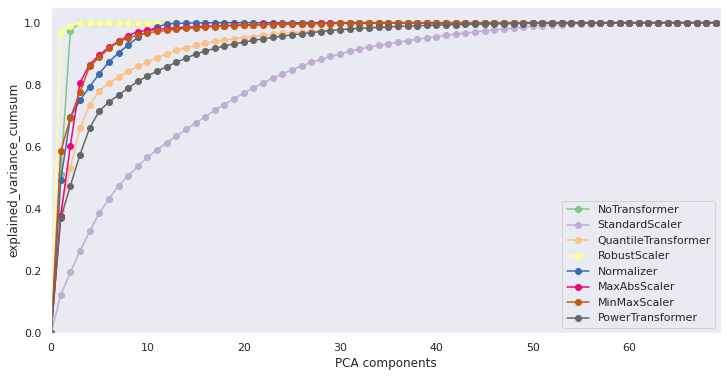

In [9]:
if 1:
    X_trans_dict, X_pca_dict,instance_pca_dict = transformer_bundle(X, is_get_instance=True)
    pca_plot_cumsum(instance_pca_dict)
    X = df.loc[df['internal'] == True]
    Y = X.label
    X = X.drop(['internal', 'label', 'ip', 'host', 'pop_srcip', 'pop_srchost','pop_destip','pop_desthost', 'pop_destport','pop_srcport', 'pop_srcprotocol','pop_destprotocol'],axis=1)
    X.loc[X.destskewstart_dur_diff == 0, 'destskewstart_dur_diff'] = 1
    idx = np.where(Y != 0)[0]
    Y_labeled = np.take(Y,idx)
    X_labeled_PCA = {}
    for key,value in X_pca_dict.items():
        X_labeled_PCA[key] = value[idx,:]


In [ ]:
#plt.rc('figure', facecolor='w')
#pca_scatter_plot(X_pca_dict, Y)

In [ ]:
#plt.rc('figure', facecolor='w')
#pca3d_scatter_plot(X_pca_dict, Y)

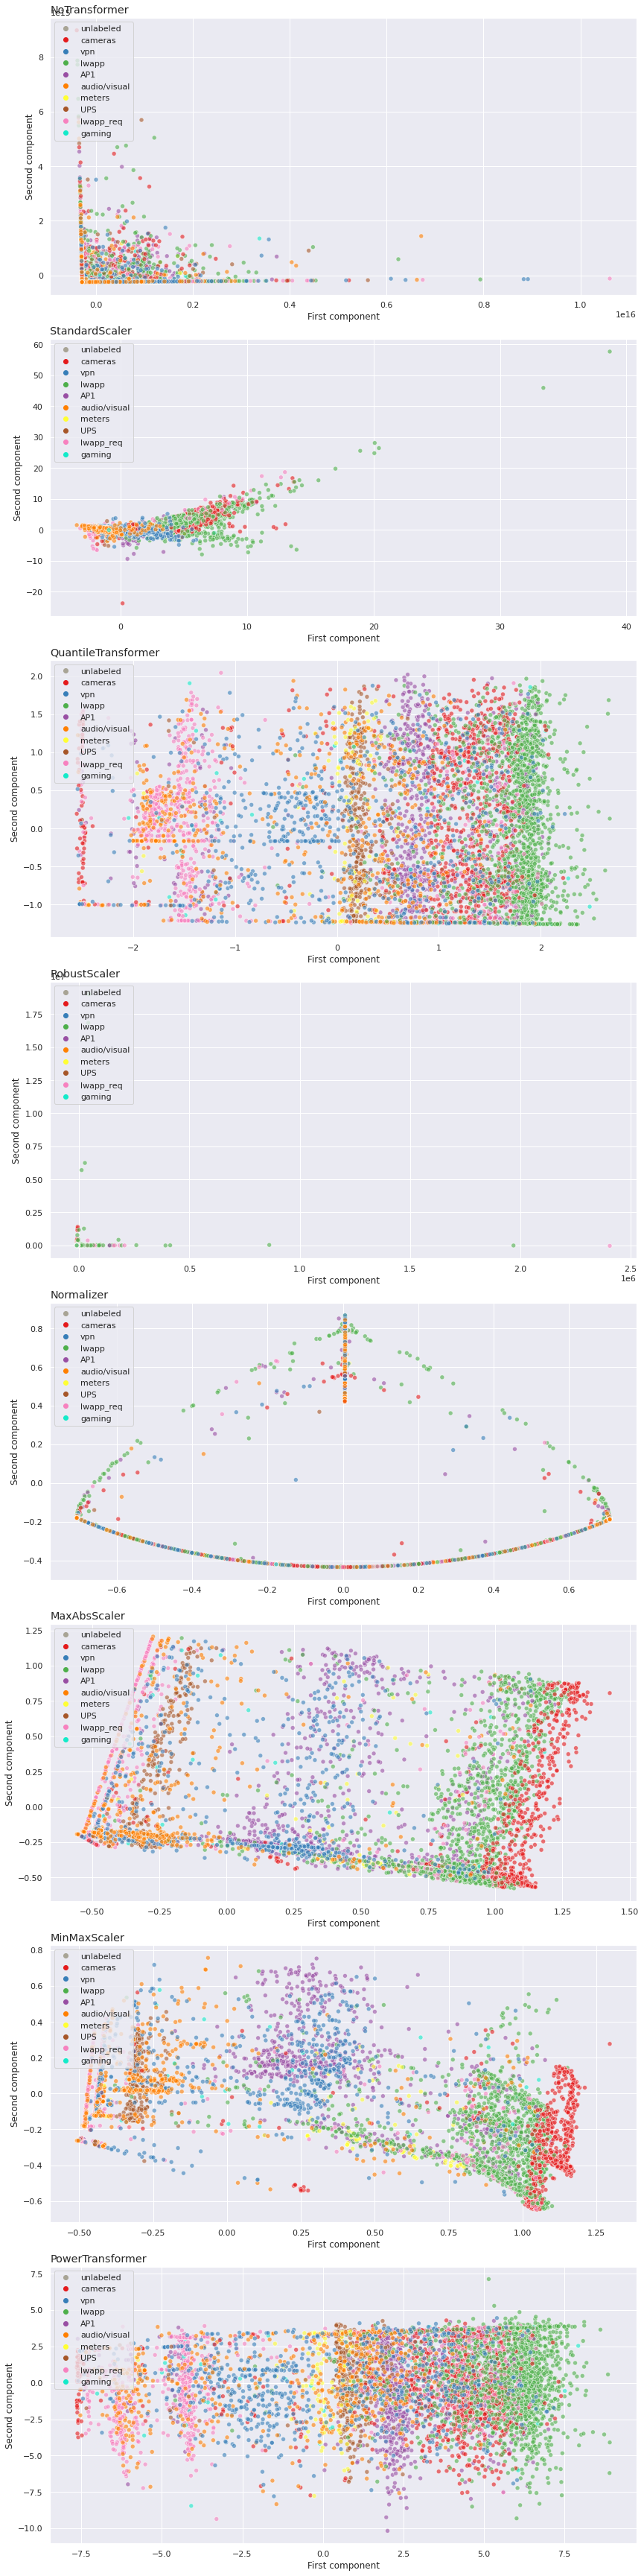

In [10]:
plt.rc('figure', facecolor='w')
pca_scatter_plot(X_labeled_PCA, Y_labeled)

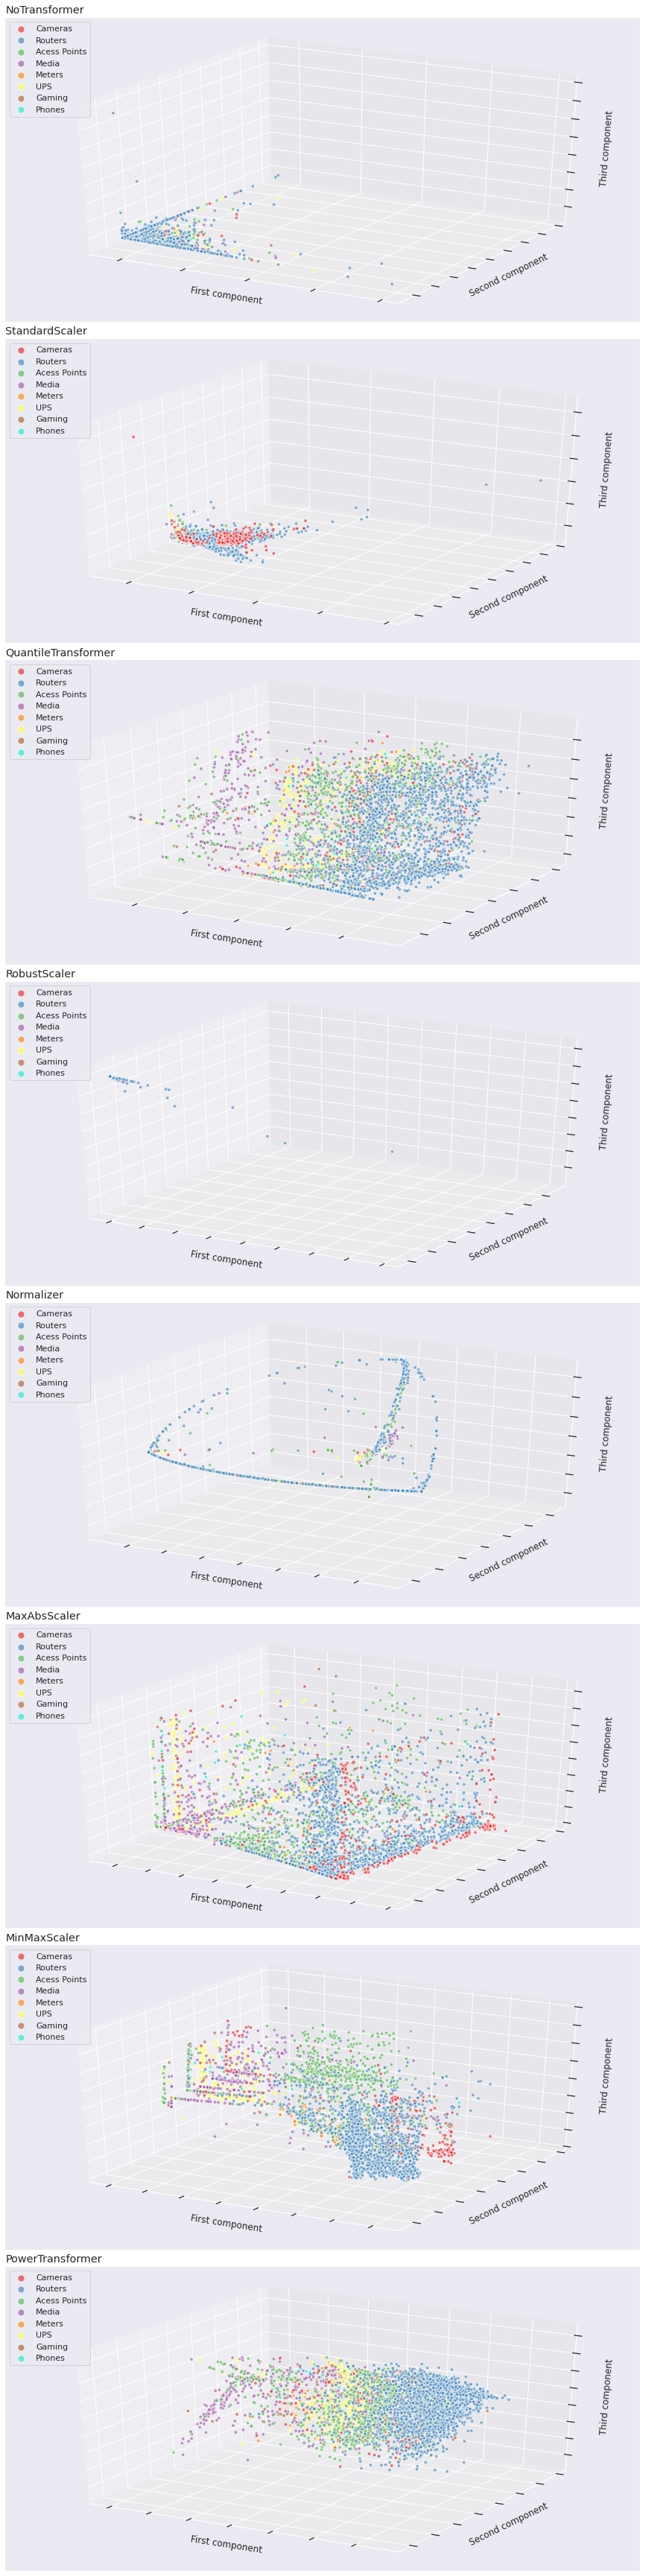

In [81]:
plt.rc('figure', facecolor='w')
pca3d_scatter_plot(X_labeled_PCA, Y_labeled)

In [ ]:
df.loc[df.label == 1,['label','ip','src_req','dest_req','pop_srcip','pop_destip','pop_srcport','pop_destport','nunq_srcport','nunq_destport']]


In [ ]:
#df.loc[((df.label == 8) & ((df.src_req < df.dest_req) | (df['dest_req']==0))),'label'] = 0
for var in np.arange(0.9,1,0.01):
    print(var)

In [16]:
def plot_distortions(x_dict, n, var=None,instance_pca=None):
    fig, axes = plt.subplots(nrows=len(x_dict.keys()), ncols=1, figsize=(9,5*len(x_dict.keys())), sharey='row')
    distortions = []
    for x,key in enumerate(x_dict.keys()):
        d = []
        if var != None:
            varidx = np.argmax(instance_pca[key].explained_variance_ratio_.cumsum() >= var)
            if varidx < 3:
                varidx = 3
        for i in range(1,n):
            kmeans = KMeans(n_clusters=i,random_state=102)
            if var != None:
                kmeans.fit(x_dict[key][:,:varidx]) 
            else:
                kmeans.fit(x_dict[key]) 
            d.append(kmeans.inertia_)
        distortions.append(d)
        this_ax = axes[x]
        this_ax.plot(range(1, n), d, marker='o')

        this_ax.set_xlabel('Number of clusters (k)')
        this_ax.set_ylabel('Distortion')
        this_ax.set_title(key, y=1, fontsize='large')
        #this_ax.legend(loc=2)
    
    plt.tight_layout(pad=1)
    plt.show()
    #return distortions
            

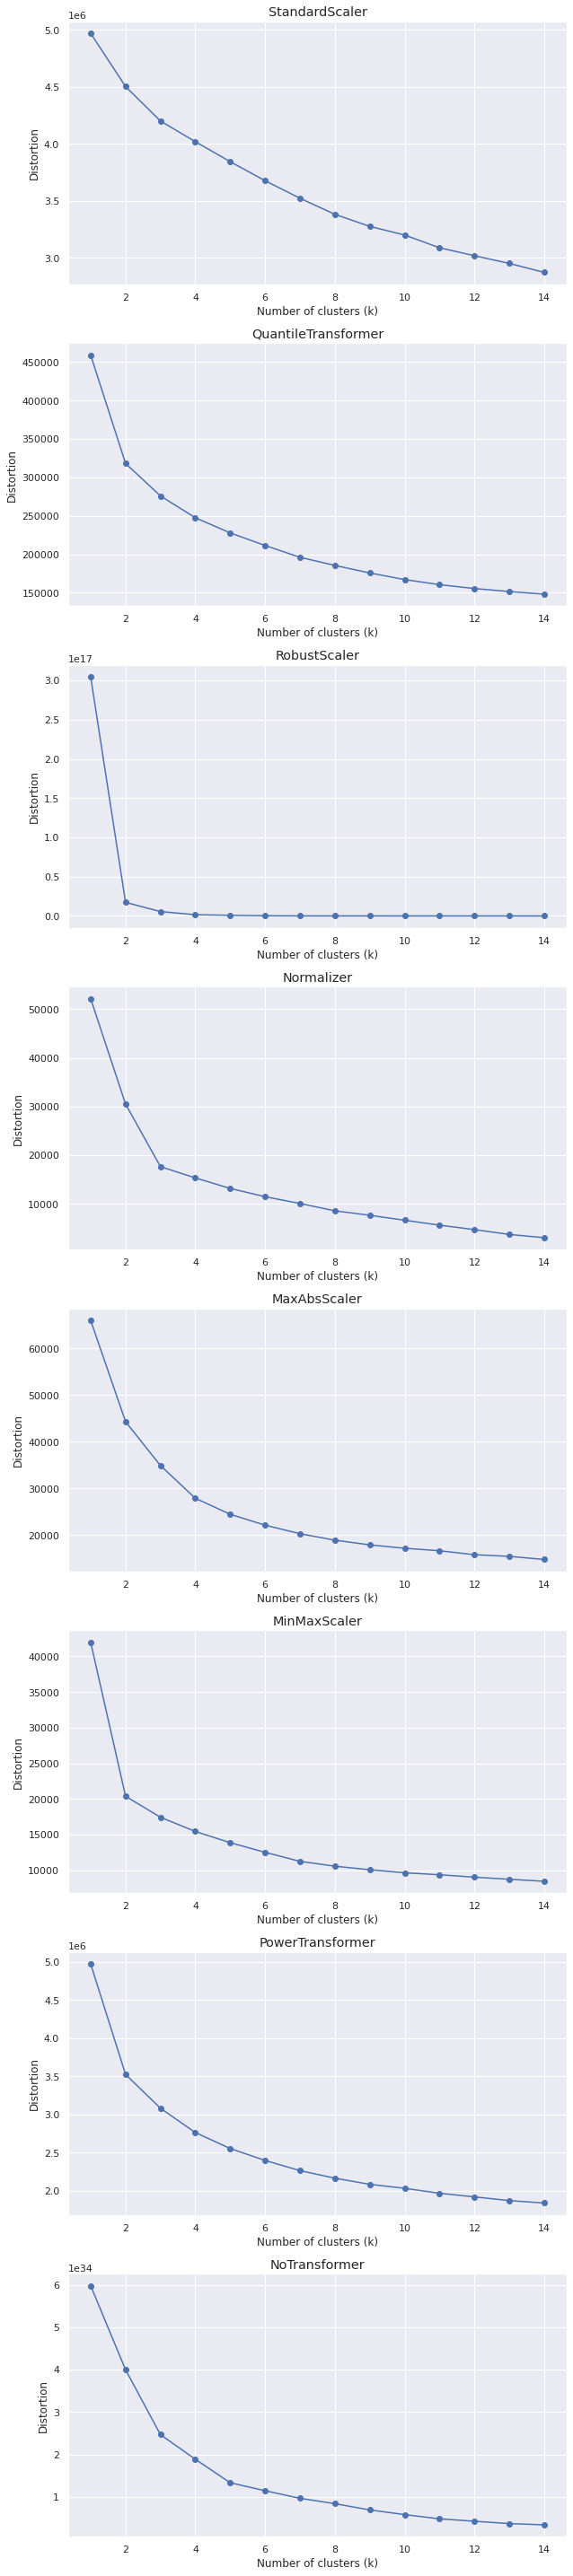

In [17]:
distortions = plot_distortions(X_trans_dict,15)

In [15]:
X_trans_dict.keys()

dict_keys(['StandardScaler', 'QuantileTransformer', 'RobustScaler', 'Normalizer', 'MaxAbsScaler', 'MinMaxScaler', 'PowerTransformer', 'NoTransformer'])

In [ ]:
'''feature_list = list(X.columns)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

rf = RandomForestRegressor(n_estimators = 20, random_state = 42)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
predictions = [int(item) for item in predictions]
metrics.accuracy_score(predictions, y_test)''';

In [ ]:
feature_list = list(X.columns)
#for key in X_trans_dict.keys():
for n in range(8,30):
    for var in np.arange(0.8,1,0.01):
        l = []
        for key in X_pca_dict.keys():
            #if key is not ['RobustScaler', 'PowerTransformer', 'NoTransformer']:
            varidx = np.argmax(instance_pca_dict[key].explained_variance_ratio_.cumsum() > var)
            if varidx < 3:
                varidx = 3
            x_train, x_test, y_train, y_test = train_test_split(X_pca_dict[key][:,:varidx], Y, test_size = 0.5, random_state = 42)
            kmeans = KMeans(n_clusters=n, random_state = 102)
            kmeans.fit(x_train) 
            y_pred = kmeans.predict(x_test)
            idx = np.where(y_test != 0)[0]
            score = metrics.accuracy_score(np.take(y_test,idx), np.take(y_pred,idx))
            if (score > 0.25):
                l.append([key, varidx, score])
        if len(l):
            print(n, var.round(2))
            for i in l:
                print(i)
            print('\n')


In [ ]:
def restore_test_idx(idx_test,old):
    return idx_test[old]
def buildCluster(n,var,key):
    #n,var,key = 19,0.99,'MinMaxScaler'
    varidx = np.argmax(instance_pca_dict[key].explained_variance_ratio_.cumsum() > var)
    indices = np.arange(np.shape(Y)[0])
    x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(X_pca_dict[key][:,:varidx], Y, indices, test_size = 0.20, random_state = 42)

    kmeans = KMeans(n_clusters=n, random_state=102)
    kmeans.fit(x_train)
    y_pred = kmeans.predict(x_test)
    print(metrics.accuracy_score(y_test, y_pred))
    #mydict = {i: np.fromiter(map(restore_test_idx, np.where(y_pred == i)[0]), dtype=np.int) for i in range(kmeans.n_clusters)}
    mydict = {i: np.fromiter(map(lambda p: restore_test_idx(idx_test,p), np.where(y_pred == i)[0]), dtype=np.int) for i in range(kmeans.n_clusters)}

        
    dictlist = []
    for key, value in mydict.items():
        temp = [key,value]
        dictlist.append(temp)
    d_counts = [ { i:0 for i in range(n)} for j in range(n) ]
    for x,l in enumerate(dictlist):
        for i in l[1]:
            d_counts[x][df.iloc[i]['label']] +=1
    for x,l in enumerate(d_counts):
        print('cluster',x, end=': ')
        for key,val in l.items():
            print(key,':', val,',', sep='', end=' ')
        print(" ")
        print(" ")
    return kmeans, dictlist, mydict, d_counts


In [ ]:
dictlist

In [ ]:
kmeans, dictlist, mydict, d_counts = buildCluster(10,0.95,'MinMaxScaler')

#### Total device counts
phones: 17985 <br>
computers: 13988 <br>
media: 500 <br>
iot: 1232 <br>
&nbsp;  gaming: 1001 <br>
&nbsp;  chromebook: 175 <br>
&nbsp;  printer: 56 <br>


In [ ]:
'''for i in range(n):
    idx = df.iloc[dictlist[i][1]].index
    c = df.loc[idx]
    print('cluster',i+1)
    extsrchosts = df2.loc[df2['pop_srchost'].isin(c['host'])].reset_index().fillna('0')
    extsrchosts.loc[extsrchosts['host'].str.contains('AMAZON'), 'host'] = 'AMAZON'
    extsrchosts.loc[extsrchosts['host'].str.contains('ATT-INT|AT&T'), 'host'] = 'AT&T'
    extsrchosts.loc[extsrchosts['host'].str.contains('AKAMAI'), 'host'] = 'AKAMAI'
    extdesthosts = df2.loc[df2['pop_desthost'].isin(c['host'])].reset_index().fillna('0')
    extdesthosts.loc[extdesthosts['host'].str.contains('AMAZON'), 'host'] = 'AMAZON'
    extdesthosts.loc[extdesthosts['host'].str.contains('ATT-INT|AT&T'), 'host'] = 'AT&T'
    extdesthosts.loc[extdesthosts['host'].str.contains('AKAMAI'), 'host'] = 'AKAMAI'
    
    extsrchosts = extsrchosts.groupby(['host'])['host'].agg(['count']).reset_index().sort_values(['count'],ascending=False)
    extdesthosts = extdesthosts.groupby(['host'])['host'].agg(['count']).reset_index().sort_values(['count'],ascending=False)

    print('most popular external hosts when src \n', extsrchosts[:30])
    print('most popular external hosts when dest \n', extdesthosts[:30])
    print('\n')''';

In [ ]:
'''#backbone
idx = df.iloc[dictlist[0][1]].index
df.loc[idx]
# external servers ? 
idx = df.iloc[dictlist[1][1]].index
df.loc[idx]
# cameras/multimedia (e.g zoom) 
idx = df.iloc[dictlist[2][1]].index
df.loc[idx]
# laptop/workstations ?
idx = df.iloc[dictlist[3][1]].index
df.loc[idx]
# phones ?
idx = df.iloc[dictlist[4][1]].index
df.loc[idx]
# IOT devices
idx = df.iloc[dictlist[5][1]].index
df.loc[idx]
'''

In [122]:
def build_palette(n, only_labeled):
    if only_labeled:
        if n < 9:
            palette = sns.color_palette('Set1', n)
        elif n < 16:
            palette = sns.color_palette('Set1', 8) +  sns.color_palette('Set2',n-8)
        elif n > 16:
            palette = sns.color_palette('Set1', 8) +  sns.color_palette('Set2',8) + sns.color_palette('Set3',n-16)
        return palette
    else:
        if n<9:
            palette = sns.xkcd_palette(['greyish']) + sns.color_palette('Set1', n-1) 
        elif n < 16:
            palette = sns.xkcd_palette(['greyish']) + sns.color_palette('Set1', 8) +  sns.color_palette('Set2',n-9)
        elif n>16:
            palette = sns.xkcd_palette(['greyish']) + sns.color_palette('Set1', 8) +  sns.color_palette('Set2',8) + sns.color_palette('Set3',n-16)
        return palette
    
'''
if n<9:
            palette = sns.color_palette('Set1', n-1) +  sns.xkcd_palette(['greyish'])
        elif n>9 & n < 16:
            palette = sns.color_palette('Set1', 8) +  sns.color_palette('Set2',n-9) + sns.xkcd_palette(['greyish'])
        elif n>16:
            palette = sns.color_palette('Set1', 8) +  sns.color_palette('Set2',8) + sns.color_palette('Set3',n-16) + sns.xkcd_palette(['greyish'])
        return palette
'''


def build_color_dict(n, labeled):
    p = build_palette(n, labeled)
    colors = {i:j for i,j in enumerate(p)}
    return colors

def calc_counts(labels,unq_y,args):
    #print('args',args)
    #print('arg1',args[0])
    #print('arg2',args[1])
    d_counts = { i:0 for i in range(1,unq_y+1)}
    x = args[0]
    i = args[1]
    for idx in i:
        if labels[idx] != 0:
            d_counts[labels[idx]] += 1
    return d_counts

def parallelize(mydict,n,dataf,unq_y):
    cores = 5
    args = []
    d_counts = [ { i:0 for i in range(1,unq_y+1)} for j in range(n) ]
    func = partial(calc_counts, dataf.label,unq_y)
    for x, value in enumerate(mydict.values()):
        args.append((x,value))
    with Pool(cores) as pool:
        #res = list(tqdm.tqdm(pool.imap(func, args),total=size))
        res = list(pool.imap(func, args))
    for i in range(len(res)):
        d_counts[i] = res[i]
    return d_counts

def restore_idx(idx,old):
    return idx[old]

def build_Kmeans(key,var,y,x_dict,n,instance_pca):
    varidx = np.argmax(instance_pca[key].explained_variance_ratio_.cumsum() > var)
    if varidx < 3:
        varidx = 3
    indices = np.arange(np.shape(y)[0])
    x_train, x_test, y_train, y_test,idx_train, idx_test = train_test_split(x_dict[key][:,:varidx], y, indices, test_size = 0.50, random_state = 42)
    kmeans = KMeans(n_clusters=n,random_state=102)
    kmeans.fit(x_train) 
    y_pred = kmeans.predict(x_test)
    mydict = {i: np.fromiter(map(lambda p: restore_idx(idx_test,p), np.where(y_pred == i)[0]), dtype=np.int) for i in range(n)}
    
    return x_train, x_test, y_train, y_test, idx_train, idx_test, kmeans, y_pred, varidx, mydict

def calc_accuracy(d_counts,n):
    count = 0
    counts = { i:0 for i in range(1,len(d_counts)+1)}
    max_count = { i:0 for i in range(1,len(d_counts)+1)}
    for x,i in enumerate(d_counts):
        print('cluster ',x+1,':',i)
        for key,value in i.items():
            counts[key] += value
            if max_count[key] < value:
                max_count[key] = value
            count+=value
    print('count:', count)
    print('accuracy:')
    for key in counts.keys():
        try:
            print(key,max_count[key]/counts[key])
        except:
            pass
    print('\n')
    return counts, max_count

def label_clusters(d_counts, counts, max_count):
    lab = { i:0 for i in range(0,len(d_counts))}
    max_acc = { i:0 for i in range(0,len(d_counts))}
    for x,i in enumerate(d_counts):
        for key,value in i.items():
            acc = value/counts[key]
            if acc >= max_acc[key] and acc >= max_acc[x]:
                max_acc[key] = acc
                lab[x] = key
        

def pca_scatter_plot_kmeans(x_dict, y, labeled=False, test=False, var=0.9, n=10, plot=True, three_d=False, instance_pca=0, dataf=0):
    kmeans_palette = build_palette(n, labeled)
    kmeans_target_order = list(range(n))
    kmeans_dict = {}
    idx_test_dict = {}
    y_pred_dict = {}
    if plot:
        if three_d:
            fig, axes = plt.subplots(subplot_kw=dict(projection='3d'), nrows=len(X_pca_dict.keys()), ncols=1, figsize=(12,6*len(X_pca_dict.keys())), sharey='row')
        else:
            fig, axes = plt.subplots(nrows=len(x_dict.keys()), ncols=1, figsize=(12,6*len(x_dict.keys())), sharey='row')
    for i,key in enumerate(x_dict.keys()):
        if key == "MinMaxScaler":
            if test:
                x_train, x_test, y_train, y_test,idx_train, idx_test, kmeans, y_pred, varidx, mydict = build_Kmeans(key,var,y,x_dict,n,instance_pca)
                kmeans_dict[key] = kmeans
                idx_test_dict[key] = idx_test
                y_pred_dict[key] = y_pred
                if labeled:
                    idx = np.where(y_test != 0)[0]
                    Y = np.take(y_pred,idx)
                    y_test = np.take(y_test,idx)
                    X = x_test[idx,:]
                    print(key, varidx)
                    acc = metrics.accuracy_score(y_test, Y)
                    print("accuracy", acc)
                    unq_y = np.max(np.unique(y))
                    d_counts = parallelize(mydict,n,dataf,unq_y)
                    print("completeness", cs(y_test, Y))
                    print("homogeneity", hs(y_test, Y))
                    if acc > 0.1:
                        counts, max_count = calc_accuracy(d_counts,n)
                    else:
                        counts, max_count = calc_accuracy(d_counts,n) #print('\n')

                else:
                    print(key, varidx, metrics.accuracy_score(y_test, y_pred))
                    X = x_test
                    Y = y_pred
            else:
                X = x_dict[key]
                Y = y
                if labeled:
                    idx = np.where(Y != 0)[0]
                    Y = np.take(Y,idx)
                    X = X[idx,:]
            if plot:
                this_ax = axes[i]
                if three_d:
                    for g in np.sort(np.unique(Y)):
                        idx = np.where(Y == g)[0]
                        this_ax.scatter(np.take(X[:,0],idx), np.take(X[:,1],idx), np.take(X[:,2],idx), '.',
                            alpha=0.6, color=color_dict[g+1], edgecolor='w', label=label_dict[g])

                    # set axis labels and title
                    this_ax.set_xlabel('First component')
                    this_ax.set_ylabel('Second component')
                    this_ax.set_zlabel('Third component')
                    this_ax.w_xaxis.set_ticklabels([])
                    this_ax.w_yaxis.set_ticklabels([])
                    this_ax.w_zaxis.set_ticklabels([])
                    this_ax.set_title(key, loc='left', fontsize='large')
                    this_ax.legend(loc='upper left',markerscale=2)
                else:
                    
                    # plot the first 2 components
                    sns.scatterplot(data=None, x=X[:,0], y=X[:,1], 
                                    hue=Y, hue_order = kmeans_target_order, 
                                    alpha=0.6, palette=kmeans_palette, ax=this_ax)

                    # set axis labels and title
                    this_ax.set_xlabel('First component')
                    this_ax.set_ylabel('Second component')
                    this_ax.set_title(key, loc='left', fontsize='large')
                    this_ax.legend(loc=2)
    if plot:
        plt.tight_layout(pad=0.5)
        plt.show()
    if test:
        return kmeans_dict, idx_test_dict, y_pred_dict
    return kmeans_dict

MinMaxScaler 7
accuracy 0.028081865778200855
completeness 0.2795199473672468
homogeneity 0.34033991152672616
cluster  1 : {1: 0, 2: 0, 3: 17, 4: 10, 5: 2, 6: 0, 7: 0}
cluster  2 : {1: 16, 2: 144, 3: 77, 4: 14, 5: 0, 6: 2, 7: 1}
cluster  3 : {1: 8, 2: 6, 3: 19, 4: 78, 5: 12, 6: 4, 7: 1}
cluster  4 : {1: 3, 2: 6, 3: 15, 4: 28, 5: 38, 6: 6, 7: 2}
cluster  5 : {1: 8, 2: 2, 3: 6, 4: 21, 5: 34, 6: 1, 7: 7}
cluster  6 : {1: 140, 2: 590, 3: 86, 4: 9, 5: 0, 6: 0, 7: 1}
cluster  7 : {1: 6, 2: 79, 3: 35, 4: 6, 5: 0, 6: 0, 7: 1}
cluster  8 : {1: 3, 2: 50, 3: 240, 4: 8, 5: 0, 6: 2, 7: 1}
cluster  9 : {1: 4, 2: 3, 3: 33, 4: 112, 5: 92, 6: 2, 7: 10}
count: 2101
accuracy:
1 0.7446808510638298
2 0.6704545454545454
3 0.45454545454545453
4 0.3916083916083916
5 0.5168539325842697
6 0.35294117647058826
7 0.4166666666666667




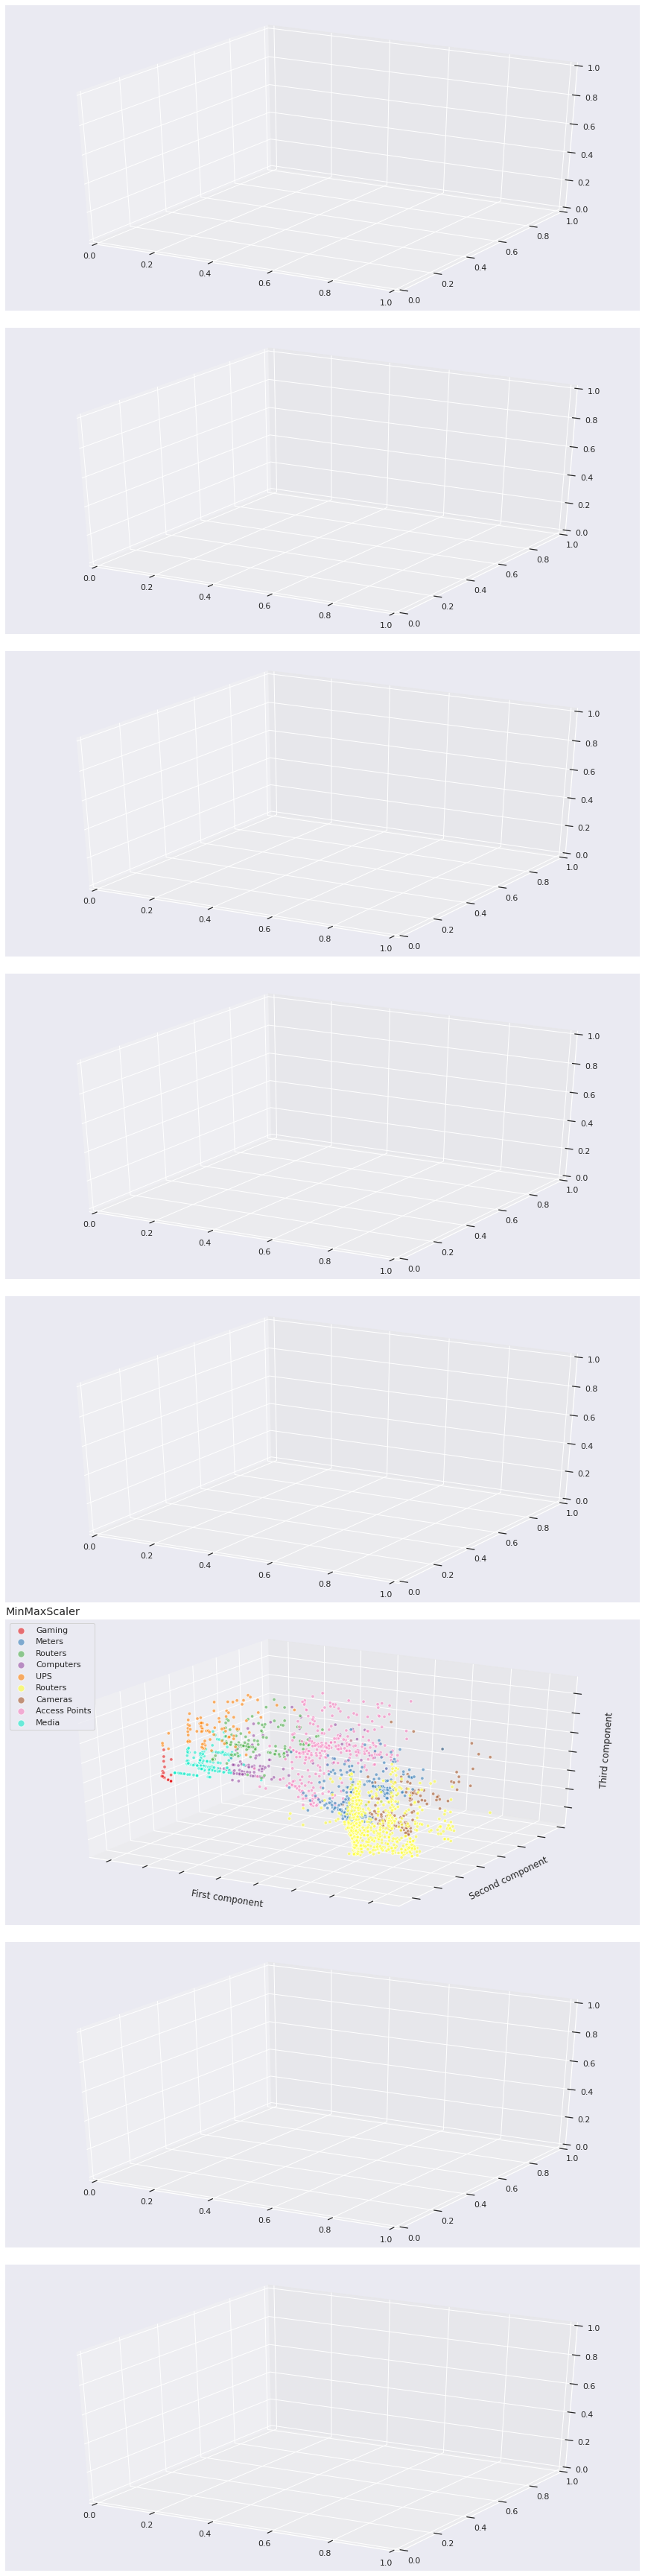

In [134]:
labels = ['Gaming','Meters', 'Routers','Computers','UPS','Routers','Cameras','Access Points','Media','Phones']
label_dict = {i:j for i,j in enumerate(labels)}
plt.rc('figure', facecolor='w')
#df.loc[df.label>3,'label'] = 0
kmeans_arr,idxdict,preddict = pca_scatter_plot_kmeans(X_pca_dict, Y, True, True,0.95,9, True,True,instance_pca_dict,df)

In [58]:
idxdict['MinMaxScaler']

array([24898,   127, 58302, ..., 64600,  8268, 53702])

In [125]:
def return_clusters(idx, labels):
    clusters = {}
    for i in np.sort(np.unique(labels)):
        clusters[i] = []
    for x,i in enumerate(labels):
        clusters[i].append(idx[x])
    return clusters
clusters = return_clusters(idxdict['MinMaxScaler'],preddict['MinMaxScaler'])

In [83]:
df.iloc[clusters[3]]

host  \
62707                                            private   
63896                                            private   
17679                 cu-res1-15 -> UCB Wireless Res1-15   
6484                  cu-rl1-1-5 -> UCB Wireless RL1-1-5   
62381                                            private   
1641                                             private   
75215                                            private   
35593                   cu-tcom-3 -> UCB Wireless Tcom-3   
53287                     cu-resedu1-3 -> eduroam Res1-3   
7158                  cu-rl1-1-8 -> UCB Wireless RL1-1-8   
44998                    cu-resgw1-4 -> UCB Guest Res1-4   
73480                   cu-spsc-ucsmgmt -> SPSC UCS MGMT   
40930               cu-engr2gw1-2 -> UCB Guest Engr2-1-2   
75319                  cu-priv-phys -> Private - Physics   
76171                   cu-priv-rgnt -> Private - Regent   
40684               cu-engr2gw1-1 -> UCB Guest Engr2-1-1   
41369               cu-engr2gw1-3 -> UCB Guest Engr2-1-3   
6270                  cu-rl1-1-4 -> UCB Wireless RL1-1-4   
65296                                            private   
45333                    cu-resgw2-1 -> UCB Guest Res2-1   
36117                   cu-tcom-4 -> UCB Wireless Tcom-4   
7875              cu-engr2-1-8 -> UCB Wireless Engr2-1-8   
40203                   cu-tcom-2 -> UCB Wireless Tcom-2   
64445                                            private   
9667              cu-engr2-1-3 -> UCB Wireless Engr2-1-3   
5326                  cu-rl1-1-1 -> UCB Wireless RL1-1-1   
14634                   cu-res1-8 -> UCB Wireless Res1-8   
7383                  cu-rl1-1-8 -> UCB Wireless RL1-1-8   
25484                 cu-rgnt2-1 -> UCB Wireless Rgnt2-1   
1272                                             private   
48444                                            private   
47123                  cu-rgntgw1-2 -> UCB Guest Rgnt1-2   
75308                  cu-priv-phys -> Private - Physics   
63590                                            private   
28315                                            private   
41624               cu-engr2gw2-1 -> UCB Guest Engr2-2-1   
6875                  cu-rl1-1-7 -> UCB Wireless RL1-1-7   
57536                  cu-hutedu1-2 -> eduroam Reshut1-2   
5319                  cu-rl1-1-1 -> UCB Wireless RL1-1-1   
20873                   cu-res2-6 -> UCB Wireless Res2-6   
41635               cu-engr2gw2-1 -> UCB Guest Engr2-2-1   
49767                    cu-tcomgw-3 -> UCB Guest Tcom-3   
26584                 cu-rgnt2-6 -> UCB Wireless Rgnt2-6   
6973                  cu-rl1-1-7 -> UCB Wireless RL1-1-7   
65771                              cu-res-ups -> RES UPS   
17832                 cu-res1-15 -> UCB Wireless Res1-15   
32178                                            private   
69684           cu-spsc-hdscam -> SPSC HDS CCURE Servers   
64963                                            private   
28461                                            private   
21659                 cu-rgnt1-6 -> UCB Wireless Rgnt1-6   
63177                                            private   
62470                                            private   
5157              cu-engr2-1-1 -> UCB Wireless Engr2-1-1   
25466                 cu-rgnt2-1 -> UCB Wireless Rgnt2-1   
4402                  cu-res-ap5 -> ResNet AP5 - Main #2   
19663                   cu-res2-3 -> UCB Wireless Res2-3   
701                                              private   
41122               cu-engr2gw1-3 -> UCB Guest Engr2-1-3   
43627                    cu-resgw1-1 -> UCB Guest Res1-1   
49101                                            private   
35434                 cu-comp1-2 -> UCB Wireless Comp1-2   
12820                   cu-res1-3 -> UCB Wireless Res1-3   
7220                  cu-rl1-1-8 -> UCB Wireless RL1-1-8   
58944                  cu-hutedu1-3 -> eduroam Reshut1-3   
32884                                            private   
27673                   cu-tcom-

In [114]:
hosts[8][0]

['TENCENT-NET-AP - Shenzhen Tencent Computer Systems Company Limited\nTencent Building, Kejizhongyi Avenue,Hi-techPark,\nNanshanDistrict, Shenzhen',
 'THEFA-3 - Facebook, Inc.',
 'GOOGLE-CLOUD - Google LLC',
 'THEFA-3 - Facebook, Inc.',
 'ZVC - Zoom Video Communications, Inc',
 'ML-772 - Meraki LLC',
 'ML-772 - Meraki LLC',
 'AT-88-Z - Amazon Technologies Inc.',
 'NOAASEL-NET - NOAA/ERL Space Environment Laboratory',
 'TP4-XXX-40-143-0-0-18 - TierPoint, LLC',
 ('cdns01.comcast.net', [], ['75.75.75.75']),
 'ZVC - Zoom Video Communications, Inc',
 'APPLE-WWNET - Apple Inc.',
 'APPLE-WWNET - Apple Inc.',
 'GOOGLE-CLOUD - Google LLC',
 'AKAMAI - Akamai Technologies, Inc.',
 'APPLE-WWNET - Apple Inc.',
 'MSFT - Microsoft Corporation',
 'GOOGLE-CLOUD - Google LLC',
 'n/a',
 'GOOGLE-CLOUD - Google LLC',
 'APPLE-WWNET - Apple Inc.',
 'AKAMAI - Akamai Technologies, Inc.',
 'APPLE-WWNET - Apple Inc.',
 'GOTO-BLOCK2 - LogMeIn, Inc.',
 'GOOGLE - Google LLC',
 'APPLE-WWNET - Apple Inc.',
 'EDGECAST

In [128]:
hosts = get_ext_hosts()

100%|██████████| 239/239 [00:21<00:00, 10.87it/s]


In [126]:
import numpy as np
from multiprocessing import cpu_count, Pool
from netaddr import IPNetwork, IPAddress
from ipwhois import IPWhois
import swifter
import tqdm
import socket,struct
import pandas as pd
import gc
gc.enable()

def check_in_subnets(ip, subnets):
    ip = IPAddress(ip)
    for subnet in subnets:
        if ip in subnet:
            return True
    return False

def private_subnets():
    ip = ['10.0.0.0','172.16.0.0','192.168.0.0']
    mask = [8,12,16]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(mask[i]))
    return ip

def cu_subnets():
    subnets = []
    with open('hosts.txt') as reader:
        for line in reader.readlines():
            l = line.rstrip().split(" | ")
            l[0] = IPNetwork(l[0])
            subnets.append(l)
    subnets.reverse()
    return subnets

def check_in_subnets_ret_name(ipstr, subnets):
    ip = IPAddress(str(ipstr))
    for subnet in subnets:
        if ip in subnet[0]:
            return subnet[1]
    return False

def whois(x):
    x = str(x).rstrip()
    s = check_in_subnets_ret_name(x,subs)
    if(s != False):
        return s
    elif(check_in_subnets(x, p)):
        return "private"
    elif(x == '0'):
        return x
    else:
        try:
            obj = IPWhois(x)
            results = obj.lookup_whois()
            l = [IPNetwork(results['asn_cidr']), results['nets'][0]['name'] + " - " + results['nets'][0]['description']]
            subs.append(l)
            return results['nets'][0]['name'] + " - " + results['nets'][0]['description']
        except:
            try:
                return socket.gethostbyaddr(x)
            except:
                return "n/a"
        

def whoiscu(x):
    x = str(x).rstrip()
    s = check_in_subnets_ret_name(x,subs)
    if(s != False):
        return s
    elif(check_in_subnets(x, p)):
        return "private"
    elif(x == '0'):
        return x
    else:
        return 'external'
            
def iscu(x):
    x = str(x).rstrip()
    s = check_in_subnets(x, subs)
    if(s != False):
        return True
    elif(check_in_subnets(x, p)):
        return True
    else:
        return False

def parallelize_hosts(data, func):
    pool = Pool(processes = 10)
    res = [None]*len(data)
    i=0
    for x in tqdm.tqdm(pool.imap_unordered(func, data), total=len(data)):
        res[i] = x
        i += 1
    pool.close()
    pool.join()
    return res
subs = cu_subnets()
p = private_subnets()



In [127]:
def get_ext_hosts():
    hosts = {}
    for i in clusters.keys():
        hosts[i] = []
        dat = df.iloc[clusters[4]]
        mask = dat.pop_srchost == "external"
        src = parallelize_hosts(dat.loc[mask,'pop_srcip'],whois)
        mask = dat.pop_desthost == "external"
        dest = parallelize_hosts(dat.loc[mask,'pop_destip'],whois)
        hosts[i].append(src)
        hosts[i].append(dest)
    return hosts


In [ ]:
# Only labeled data plotted
plt.rc('figure', facecolor='w')
pca_scatter_plot_kmeans(X_pca_dict, Y, True, False,0.95,n)

In [ ]:
# only labeled data clustering results
plt.rc('figure', facecolor='w')
pca_scatter_plot_kmeans(X_pca_dict, Y, True, True,0.95,n)

In [ ]:
plt.rc('figure', facecolor='w')
pca3d_scatter_plot_kmeans(X_pca_dict, Y, True,False,0.95,n)

In [ ]:
plt.rc('figure', facecolor='w')
pca3d_scatter_plot_kmeans(X_pca_dict, Y, True,True,0.99,20)

In [ ]:
'''
gaming console ports
27000 - 27050
1935, 3478-3480 , 983(ps)
3074 (xbox)
16403 (apple game center)

printers
22370 (hp)
8609 (canon)
5548 (OKI)
5309 (jprinter)
4007 (printerbuzz)
3911 (printer status)
3910 (printer request)
2291 (share)
631 (mac share)
515
137-9
9100-2
5353

phones
5228 (android googleplay store)
5055 yahoo messenger
8192 spytech

computers
6882 bittorrent
''';

In [ ]:
'''cluster = LocalCluster(processes=True, n_workers=10, threads_per_worker=1)
client = Client(cluster)
inputfile = '/data/maxim/data/newest.csv'
df = dd.read_csv(inputfile)
r = client.compute(df.loc[df.srcaddr == '172.20.126.108'])
progress(r)''';